# Loading libraries



In [473]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go


Source of Dataset: https://osmihelp.org/research

"With over 1200 responses, we believe the 2014 Mental Health in Tech Survey was the largest survey done on mental health in the tech industry."

Problem Statements :

1. Create a model that, to a satisfying extent, has the ability to predict if an employee in the tech-industry would seek out mental-health treatment.

2. Figure out what the key features are which have the potential to lead to a mental health problem in the tech-industry.

Business use-case

Core of the Problem: Almost 86% of employees report improved work performance and lower rates of absenteeism after receiving treatment for depression, according to an April 2018 article in the Journal of Occupational and Environmental Medicine. This shows the employers and companies an effective method to increase their ability to retain valuable employees. By providing employees access to mental health benefits, the company can begin to create a culture of understanding at their tech-firms. And having employees who feel cared for is not just the right thing to do, but it’s also good for business.

Source - Journal of Occupational and Environmental Medicine: April 2018 - Volume 60 - Issue 4 - p 322-330
doi: 10.1097/JOM.0000000000001271

The models developed here can provide companies with a tool to better understand the mental-health challenges of their employees, and how to effectively use company resources to handle them. Furthermore, the models can provide assistance in finding cost-cutting methods to prevent employees from seeking expensive treatments provided by company benefits by reducing the risk of their employees suffering mental-health problems in the first place.
Increased employee satisfaction leads to a higher retention rate, which in turn leads to increased employer satisfaction.

In [380]:
# The option "parse_dates" casts any column containing dates to pd.to_datetime(). We need to provide the column containing a date
data = pd.read_csv("../data/raw/raw_menthal_health_in_tech.csv",parse_dates=['Timestamp'])
#parse_date tells the column 'Timestamp' that its datetime dtype
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [381]:
data.shape

(1259, 27)

In [382]:
data.info()
#all object except Age and Timestamp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  1259 non-null   datetime64[ns]
 1   Age                        1259 non-null   int64         
 2   Gender                     1259 non-null   object        
 3   Country                    1259 non-null   object        
 4   state                      744 non-null    object        
 5   self_employed              1241 non-null   object        
 6   family_history             1259 non-null   object        
 7   treatment                  1259 non-null   object        
 8   work_interfere             995 non-null    object        
 9   no_employees               1259 non-null   object        
 10  remote_work                1259 non-null   object        
 11  tech_company               1259 non-null   object        
 12  benefi

DATA PREPARATION/CLEANING

In [383]:
#converting all the column names into lower case
data.columns = data.columns.str.lower()

In [384]:
#checking to see for salient values like NaN and missing, etc.
data.describe(include='all')

C:\Users\User\AppData\Local\Temp\ipykernel_24308\1669283049.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,1259,1.259000e+03,1259,1259,744,1241,1259,1259,995,1259,...,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,NaN,49,48,45,2,2,2,4,6,...,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 12:44:51,NaN,Male,United States,CA,No,No,Yes,Sometimes,6-25,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,NaN,615,751,138,1095,767,637,465,290,...,563,490,925,774,516,1008,557,576,1075,5
first,2014-08-27 11:29:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-02-01 23:04:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.942815e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.818299e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-1.726000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [385]:
data.isnull().sum()

timestamp                       0
age                             0
gender                          0
country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

age is looking like it needs work, and there are a bunch of missing values. Also, I can drop certain columns like timestamp and comment as they carry no importance in my treatment prediciton. More on that in the next cell.
Additionally, 'work_interference' will need to be looked in to. Due to the fact that there is a small number of only 18 data points 'self_employed' NaN values, we can just drop them.

In [386]:
data['country'].value_counts()
#this is misleading. Most participants are from the US. This might lead to a faulty conclusion that most people in need of treatment are from the US. 

United States             751
United Kingdom            185
Canada                     72
Germany                    45
Ireland                    27
Netherlands                27
Australia                  21
France                     13
India                      10
New Zealand                 8
Poland                      7
Switzerland                 7
Sweden                      7
Italy                       7
South Africa                6
Belgium                     6
Brazil                      6
Israel                      5
Singapore                   4
Bulgaria                    4
Austria                     3
Finland                     3
Mexico                      3
Russia                      3
Denmark                     2
Greece                      2
Colombia                    2
Croatia                     2
Portugal                    2
Moldova                     1
Georgia                     1
Bahamas, The                1
China                       1
Thailand  

I will drop the 'country' column, 'timestamp', 'comments', and the 'state' one as well. They have no bearing on my analysis, because the method of collection has not been specified and can therefore not be accurately analyzed to a satisfying degree.
Notice: 'country' and 'state' only show where collection took place, creating great imbalance, and does not specify any meaning on predicting mental health or treatment measures.
Furthermore, the number of 'self_employed' participants is negligible, while 'timestamp' is simply when the data was collected.

In [387]:
data = data.drop(['country','state','timestamp','comments', 'self_employed'], axis = 1)

In [388]:
#checking the entry types for gender, commonly a source for cleaning
data['gender'].value_counts().reset_index()

,index,gender
0,Male,615
1,male,206
2,Female,121
3,M,116
4,female,62
5,F,38
6,m,34
7,f,15
8,Make,4
9,Male,3


As expected, the gender column is a mess. Must be corrected. I will create a third gender-type called 'Other' for all those who did not answer and do not identify as Male or Female.

In [389]:
data['gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

data['gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

data["gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Other', inplace = True)

In [390]:
#checking to see the new output
data['gender'].value_counts().reset_index()

,index,gender
0,Male,991
1,Female,247
2,Other,21


There is a clear imbalance of genders. Most participants of the survey are male. However, this does not suggest in any way that most people with mental-health issues identify as male. For all we know, this could imply that most employees in the tech industry are male. We just don't know from this dataset alone, because it provides no information to explain the imbalance.

Using a quick google search it was shown that the ratio of men to women in the technology industry is about 3:1. This is based on the fact that only 25% of computing and mathematical jobs in the U.S. are held by women. The U.S. is also the country where most participants answers were collected from.

In [391]:
#let us see what we can do in order to correct the 'age' column.
data['age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 40             33
 39             33
 43             28
 22             21
 41             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 48              6
 50              6
 20              6
 51              5
 49              4
 56              4
 57              3
 54              3
 55              3
 47              2
 60              2
 99999999999     1
 5               1
-1               1
 11              1
 8               1
 61              1
 53              1
-29              1
-1726            1
 65              1
 62              1
 58              1
 329             1
 72         

Negative ages, people living to a million years, and children. But not that many. Will be corrected in the cell below.

In [392]:
#locking the ages to range from 16 to 75
data.loc[data.age<12,'age']=16
data.loc[data.age>75,'age']=75

In [393]:
 #checking to see if it there's anyone younger than 16 or older than 75. should return tables with no rows.
display(data[data['age'] > 75].head())
display(data[data['age'] < 16].head()) 

,age,gender,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence


,age,gender,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence


<AxesSubplot: >

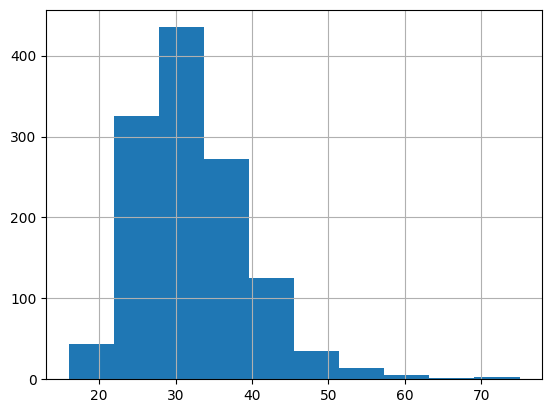

In [394]:
#looks like a realistic plot of age-ranges for working-people. that's good.
data['age'].hist()

In [395]:
round((data.isna().sum()/data.shape[0])*100,2)

age                           0.00
gender                        0.00
family_history                0.00
treatment                     0.00
work_interfere               20.97
no_employees                  0.00
remote_work                   0.00
tech_company                  0.00
benefits                      0.00
care_options                  0.00
wellness_program              0.00
seek_help                     0.00
anonymity                     0.00
leave                         0.00
mental_health_consequence     0.00
phys_health_consequence       0.00
coworkers                     0.00
supervisor                    0.00
mental_health_interview       0.00
phys_health_interview         0.00
mental_vs_physical            0.00
obs_consequence               0.00
dtype: float64

In [396]:
#dealing with the work_interfere column. after testing to find a pattern, this is the most interesting result. explanation is found below.
data[data['work_interfere'].isna()]['treatment'].value_counts()

No     260
Yes      4
Name: treatment, dtype: int64

The output of the cell above shows that out of the 264 NaN values for the question "Whether mental health interferes with work?', 260 have answered that they WOULD NOT seek treatment. Thats over 98% !
This can conclude that the NEVER response in the work_interfere column is a reasonable consideration to fill those missing values for the participants who did not fill it out.

In [397]:
#replacing NaN with Never as explained above
data['work_interfere'].fillna('Never',inplace = True)

In [398]:
#checking to see if my dataset is clean
round((data.isna().sum()/data.shape[0])*100,2)

age                          0.0
gender                       0.0
family_history               0.0
treatment                    0.0
work_interfere               0.0
no_employees                 0.0
remote_work                  0.0
tech_company                 0.0
benefits                     0.0
care_options                 0.0
wellness_program             0.0
seek_help                    0.0
anonymity                    0.0
leave                        0.0
mental_health_consequence    0.0
phys_health_consequence      0.0
coworkers                    0.0
supervisor                   0.0
mental_health_interview      0.0
phys_health_interview        0.0
mental_vs_physical           0.0
obs_consequence              0.0
dtype: float64

In [399]:
#saving clean data
data.to_csv(r'../data/clean/clean_data.csv', index=False)

Exploratory Data Analysis (EDA)

Have tech-industry employees sought out treatment for a mental health condition?

In [400]:
#This is our target/dependent variable.
plt.figure(figsize=(8,8))
fig = px.histogram(data, x = 'treatment',color='treatment', width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()


<Figure size 800x800 with 0 Axes>

General insight

Almost half the participants are seeking treatment. This is a significant ratio. 
Studies have revealed that mental health problems can be a major risk factor to an individual. We must ensure that the people seeking help are provided with help.

There is no class imbalance here. Even if there was one, up- or downsampling is not an option on the target variable.

What age gets/does not get treatment?

In [401]:
fig = px.histogram(data, x = 'age' , color = 'treatment', width=800, height=400 )
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="peachpuff",
)

fig.show()

Here we can see that most people seeking/and not seeking mental-health treatment are within the age-range of 25 to 35. This imbalance is most likely due to the fact that most participants/employees are in that age group.
It does not reveal anything related to age and its propensity to mental-health.

Does your mental-health cause an intefererence with your work?

<AxesSubplot: xlabel='work_interfere', ylabel='count'>

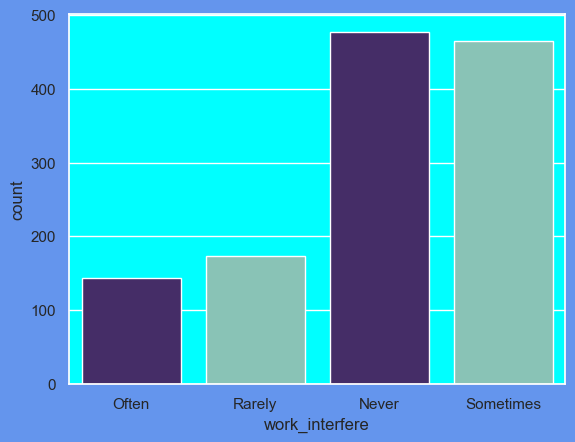

In [501]:
sns.set(rc={'axes.facecolor':'cyan', 'figure.facecolor':'cornflowerblue'})
sns.countplot(data = data , x = 'work_interfere', palette=['#432371',"#7fcdbb"])


In [481]:
fig = px.histogram(data, x = 'work_interfere',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",)

fig.show()


In [404]:
data['work_interfere'].value_counts(normalize = True)

Never        0.378872
Sometimes    0.369341
Rarely       0.137411
Often        0.114376
Name: work_interfere, dtype: float64

General insight

Around 62% of participants have noted that they experience interference at work with the ratios of rarely, sometimes, and frequently. 38% repoprted no interference ever.
It's interesting to observe that even the "never" interferes-with-work mental health group contains a number of people that still want to get treatment. This is possibly done to prevent future stress at work. These stress-factors can be induced by the large amount of pressure and performance requirements provided by the employer that might be beyond the scope of the employee.
If you are running a tech company, or any company, you should consider providing resources for employees seeking treatment. This step can help in boosting employee experience and could increase their productivity and retention-rate.

Does the participant have a family-history of mental illness?

In [485]:
fig = px.histogram(data, x = 'family_history',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",)

fig.show()

General insight

People who have family history of mental illness are more likely to seek treatment.
People with family history are more likely to seek treatment than without family history.
Family history is very likely to be an important feature in predicting the choice for treatment.

Does the company you work for provide mental health benefits?

<AxesSubplot: xlabel='benefits', ylabel='count'>

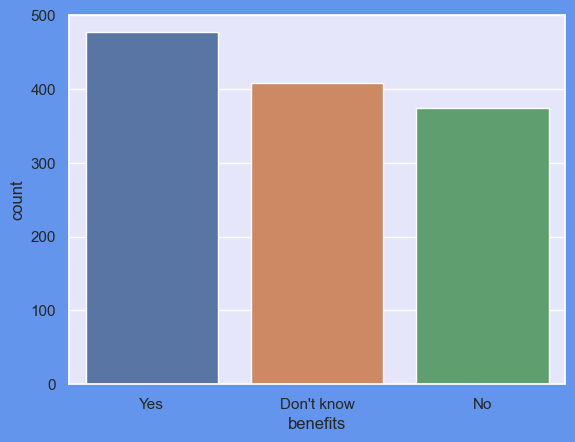

In [508]:
sns.set(rc={'axes.facecolor':'lavender', 'figure.facecolor':'cornflowerblue'})
sns.countplot(data = data , x = 'benefits')

In [407]:
data['benefits'].value_counts(normalize = True)

Yes           0.378872
Don't know    0.324067
No            0.297061
Name: benefits, dtype: float64

In [408]:
fig = px.histogram(data, x = 'benefits',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General insight

Here we observe that 38% of the respondents stated that their company provides them with benefits related to mental-health. Additionally, a not so insignificant number of 32% had no knowledge of whether their company provided such benefits.
Coming to the second graph,we see that for the people who responded with "Yes", around 64% of them said that they were seeking treatment. So we can see the employer resources are utilized to a larger extent, which is expected.
The worker retention rate and job satisfaction and productivity would compenstate for the extra cost for such programs.
Surprisingly, for the participants who responded with "No", 48% of them sought out mental health treatment.

Does your employer provide resources to learn more about mental health issues and how to seek help?

<AxesSubplot: xlabel='seek_help', ylabel='count'>

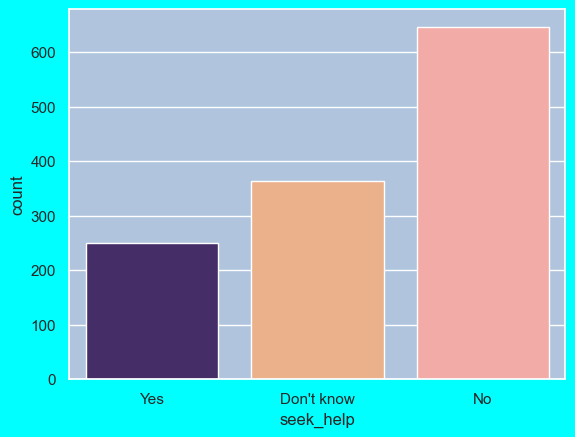

In [511]:
sns.set(rc={'axes.facecolor':'lightsteelblue', 'figure.facecolor':'cyan'})
sns.countplot(data = data , x = 'seek_help', palette=['#432371',"#FAAE7B","#ff9f9b"])

In [410]:
fig = px.histogram(data, x = 'seek_help',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General insight

The majority of companies do not provide any resources. Furthermore, many participants do not know whether their employer provides these resources. Those that do provide it, show a majority of participants partaking in treatment.
This insight is important, especially as a member of Human Rerources. Providing the correct resources to your employess makes a difference.

Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

<AxesSubplot: xlabel='anonymity', ylabel='count'>

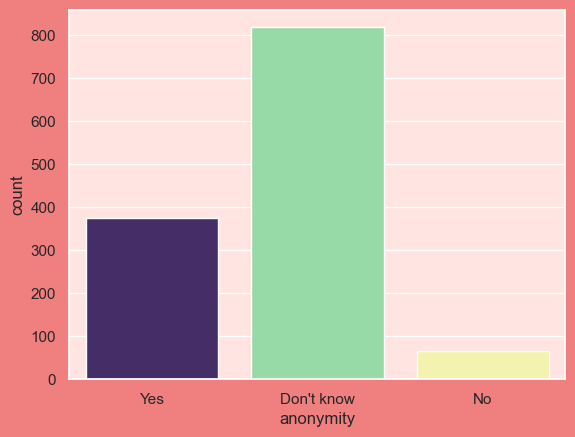

In [512]:
sns.set(rc={'axes.facecolor':'mistyrose', 'figure.facecolor':'lightcoral'})
sns.countplot(data = data , x = 'anonymity', palette=['#432371',"#8de5a1","#fffea3"])

In [412]:
fig = px.histogram(data, x = 'anonymity',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General Insight

The majorioty of people do not know if their anonymity is protected should they decide to partake in treatment.
Those who responded with "Yes" show an increased rate of seeking out treatment. It is therefore important to create the type of environment that fosters trust.
Also, only 65 respondents said "No". This is a good sign.
More needs to be done to clarify the anonimity of those seeking support and help.

How easy is it for you to take medical leave for a mental health condition?

In [413]:
fig = px.histogram(data, x = 'leave',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General Insight

This is interesting, because it shows 2 things I did not expect.
Frist, the ratio of treatment-seekers to no-treatment, for those who find it easy to take medical leave, is almost exactly even.
Second, those who find it difficult to seek medical leave, are more likely to seek treatment. Are those factors related?

Do you think that discussing a mental health issue with your employer would have negative consequences?

<AxesSubplot: xlabel='mental_health_consequence', ylabel='count'>

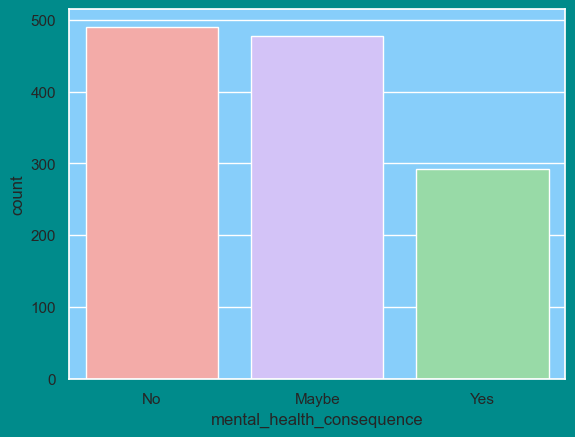

In [513]:
sns.set(rc={'axes.facecolor':'lightskyblue', 'figure.facecolor':'darkcyan'})
sns.countplot(data = data , x = 'mental_health_consequence', palette=['#ff9f9b',"#d0bbff","#8de5a1"] )

In [415]:
data['mental_health_consequence'].value_counts(normalize = True)

No       0.389198
Maybe    0.378872
Yes      0.231930
Name: mental_health_consequence, dtype: float64

In [518]:
fig = px.histogram(data, x = 'mental_health_consequence',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General Insight

This is very telling, as up to 61% of respondents feel as though sharing their mental-health issues could have a negative impact on their career.
Interestingly though, within the groups who fear reprucussions, the majority does seek out treatment, while the majority of those who fear no negative reprucussions do not seek out treamtent.
Are those factors related? Is the fear and pressure of not revealing yourself pushing employees to seek help? More research needs to be done here.

Would you be willing to discuss a mental health issue with your coworkers?

<AxesSubplot: xlabel='coworkers', ylabel='count'>

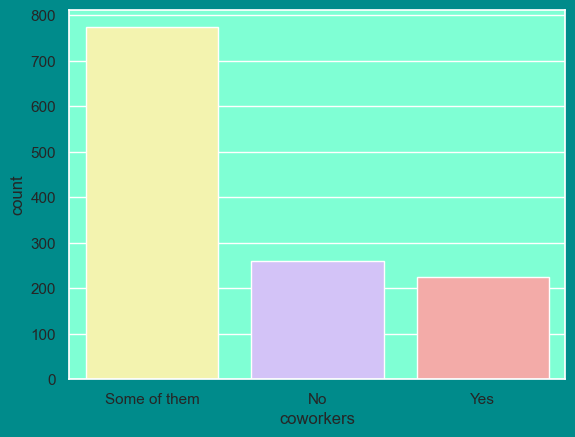

In [517]:
sns.set(rc={'axes.facecolor':'aquamarine', 'figure.facecolor':'darkcyan'})
sns.countplot(data = data , x = 'coworkers', palette=['#fffea3',"#d0bbff","#ff9f9b"] )

In [418]:
data['coworkers'].value_counts(normalize = True)

Some of them    0.614774
No              0.206513
Yes             0.178713
Name: coworkers, dtype: float64

In [419]:
fig = px.histogram(data, x = 'coworkers',color='treatment',barmode='group', width=800, height=400)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

General Insight

Most people ("Some of them" + " Yes" = 79%) would be willing to discuss mental health issues with their coworkers. 
In those groups, the majority also seeks out treatment. 
Interestingly, for those who feel they have no coworkers to talk to, the majority do not seek out treatment.
This could be due to the preceived social acceptance of mental health issues at work.


First steps towards preparing the prediction models

In [420]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.20,stratify=data['treatment'],random_state=42 )

In [421]:
print(f'Train_data number : {train_data.shape}\n Test data number : {test_data.shape}')

Train_data number : (1007, 22)
 Test data number : (252, 22)


X/Y SPLIT

In [422]:
# Do the X/y split to seperate dependent from independent columns
X = data.drop('treatment', axis=1)
y = data['treatment']

Encode Categoricals

In [423]:
# Encode categorical columns to numerical
X = pd.get_dummies(X, drop_first=True)

Train/Test Split

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply Standard Scaler

In [425]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

with open(r'../scaler/standard_scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

Perform a gridsearch for RandomForestClassifier

In [426]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [4,4],
    'min_samples_split': [4,4]
}

In [427]:
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)    

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [4, 4],
                         'min_samples_split': [4, 4]})

In [428]:
gs.best_params_

{'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 4}

In [429]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.5731225296442688

What does Cohen's kappa tell you?
Cohen's kappa is a metric often used to assess the agreement between two raters. It can also be used to assess the performance of a classification model.

In [430]:
with open(r'../model/random_forest.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

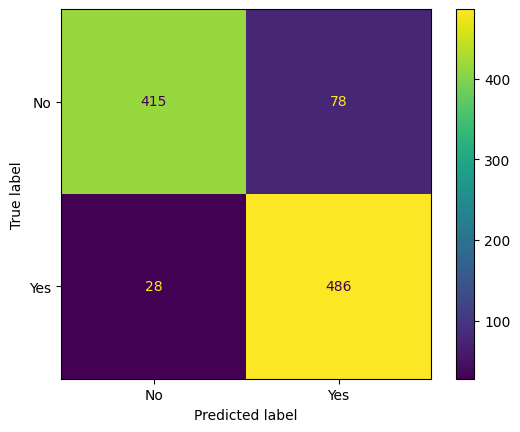

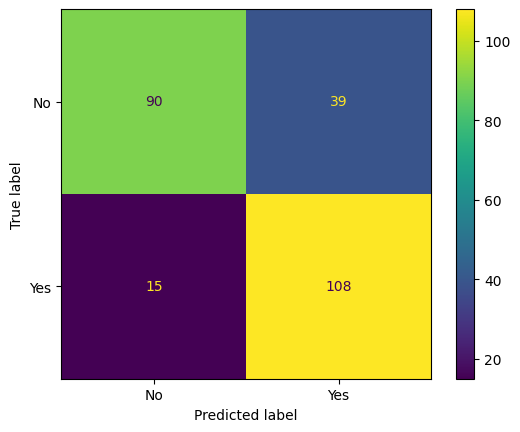

In [431]:
# Plot confusion matrix for train set prediction
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

# Plot confusion matrix for test set prediction
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [432]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.8113541204866754
Average accuracy: 0.7022745098039216


Perform a GridSearch for LogisticalRegression 

In [433]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [300]
}

gs2 = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs2.fit(X_train_scaled, y_train)

c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\User\Deskto

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']})

In [434]:
# Show best parameters for LogisticRegression
gs2.best_params_

{'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}

In [435]:
# Store model
with open(r'../model/logistic_reg.pickle','wb') as file:
    pickle.dump(gs2.best_estimator_, file)

In [436]:
y_train_pred = gs2.predict(X_train_scaled)
y_test_pred  = gs2.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)
#better than RFC, but not by much

0.604296212549463

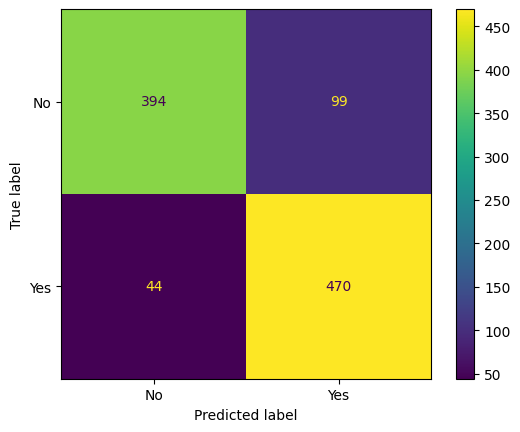

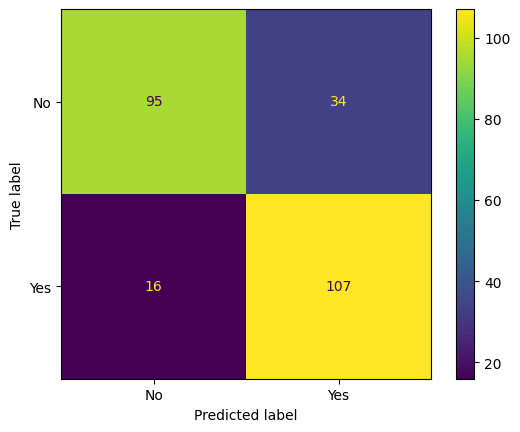

In [437]:
# Plot confusion matrix 
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [438]:
results = cross_val_score(gs2.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs2.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")
#better than RFC

Average accuracy: 0.8351362001871829
Average accuracy: 0.7656470588235293


Perform a GridSearch for KNN-Classifier

In [439]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs3 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs3.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.698 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.673 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.682 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.692 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.698 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.678 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.692 total time=   0.0s
[CV

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [440]:
y_train_pred = gs3.predict(X_train_scaled)
y_test_pred  = gs3.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)
#lowest kappa so far

0.4245480494766889

In [441]:
results = cross_val_score(gs3.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs3.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")
#no surprise it's the lowest score again

Average accuracy: 0.716969607408502
Average accuracy: 0.6624313725490196


In [442]:
# Store model
with open(r'../model/knn.pickle','wb') as file:
    pickle.dump(gs3.best_estimator_, file)

So finally, a big part of our task has been completed.
The strongest model we have developed which can predict whether an employee seeks mental health treatment or not is the LogisticRegression model (gs2).
We will therefore use that model to extract the key features in figuring out whether or not an individual will choose to get mental-health assistance.

In [443]:
#gs2.fit(X,y)
#importance = gs2.best_estimator_.coef_[0]
#importance is a list so you can plot it. 
#feat_importances = pd.Series(importance)
#feat_importances.nlargest(10).plot(kind='barh',title = 'Feature Importance')

In [444]:
features = list(X_train.columns)

In [445]:
data1 = {'feature_names':features,'feature_importance': gs2.best_estimator_.coef_[0]}
featureimp_df = pd.DataFrame(data1)
featureimp_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

Text(0.5, 1.0, 'Key Features')

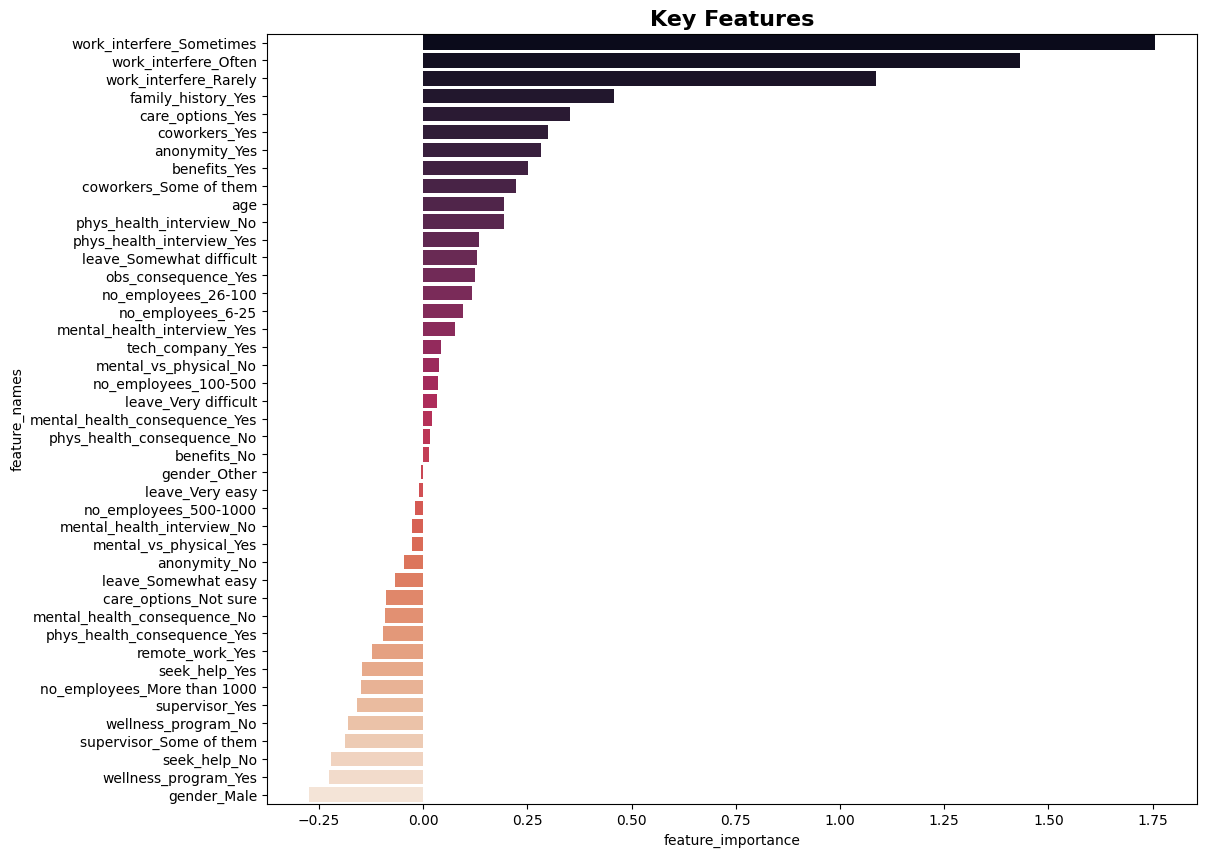

In [446]:
plt.figure(figsize=(12,10))
sns.barplot(data = featureimp_df, x = 'feature_importance' , y = 'feature_names' , palette='rocket')
plt.title("Key Features", fontsize=16, fontweight="bold")

Conclusion:

- According to our results, work interference, no matter how often, is the largest contributer in predicting whether or not an employee would seek out treatment. This goes to show how important the perceived quality of their work is to the employee. If the participants sense that their mental-health gets in the way of doing their job, they are more willing to do something about it. 
- It seems that the whether or not an employee's mental health issues interfering with the work is the the best question to ask for an employer or trusted coworker in order to understand if the employee will seek treatment.
- Family history, trusted coworkers and care options(programs and benfits) provided by company are also influential for employees who want to get treatment.
- The remaining features seem to have a lesser contribution in understanding the employees treatment needs.
- Acknowledging some of these features early can possibly help support an individual who may be experiencing a mental health issues in order to help connect them with the appropriate company resources.
- Finally, preventing the rise of mental health issues in the first place for employees can reduce the amount of those seeking treatment. Prevention is key, and needs further study.